In [1]:
import os, io
from pathlib import Path
import math
from collections import defaultdict
from itertools import chain
from dataclasses import dataclass, field
import sqlite3
import logging
import logging.handlers
import multiprocessing as mp

from tqdm.notebook import tqdm
from PIL import Image, ImageDraw

import numpy as np
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from utils import *
from hdc import *

In [2]:
LOG = Logging()

config_var = 'SQLITE3_VECTOR_GRID_0_1024'
config = Config(config_var)
RNG = np.random.default_rng()

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a

print(f'xp = {xp.__name__}')

hdc = Hdc(config.hdc_n, np)

xp = numpy


In [3]:
def ensure_dataset_folder():
    if not os.path.exists(config.dataset_path):
        print(f'Creating "{config.dataset_path}"')
        os.mkdir(config.dataset_path)

def is_table_exists(db_con, table_name):
    df = pd.read_sql('SELECT name FROM sqlite_master WHERE type=:type AND name=:table_name', params={'type': 'table', 'table_name': table_name}, con=db_con)
    return len(df) > 0

def is_table_empty(db_con, table_name):
    cur = train_db_con.cursor() 
    return len(cur.execute(f'SELECT * FROM {table_name} LIMIT 1').fetchall()) < 1

def drop_table_safe(db_con, tn):
    if is_table_exists(db_con, tn):
        db_con.cursor().execute(f'DROP TABLE {tn}')
        db_con.commit()

def get_full_db_file_name(db_file_name):
    return os.path.join(config.dataset_path, config.db_file_name_prefix + db_file_name)

ensure_dataset_folder()
hdv_db_con = sqlite3.connect(get_full_db_file_name(config.hdv_db_file_name), autocommit=False)
train_db_con = sqlite3.connect(get_full_db_file_name(config.train_db_file_name), autocommit=False)
test_db_con = sqlite3.connect(get_full_db_file_name(config.test_db_file_name), autocommit=False)

# Load MNIST

In [4]:
dataset_source = os.path.join(config.dataset_source)

In [5]:
import struct
from array import array

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        
        images = []
        
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images.append(img)
        
        return np.array(images), np.array(labels)
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)     

CPU times: user 126 ms, sys: 74.7 ms, total: 200 ms
Wall time: 200 ms


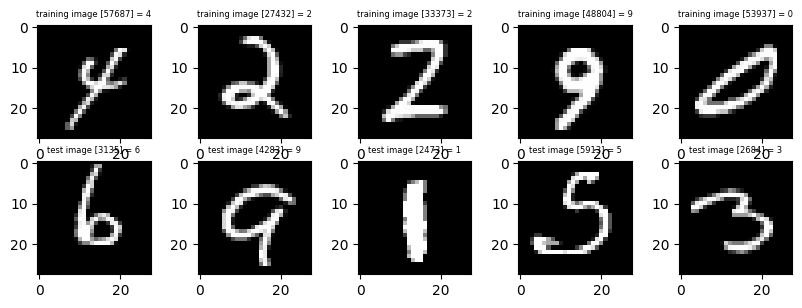

In [6]:
%%time
import random

#
# Set file paths based on added MNIST Datasets
#
training_images_filepath = os.path.join(dataset_source, 'train-images-idx3-ubyte')
training_labels_filepath = os.path.join(dataset_source, 'train-labels-idx1-ubyte')
test_images_filepath = os.path.join(dataset_source, 't10k-images-idx3-ubyte')
test_labels_filepath = os.path.join(dataset_source, 't10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(10,5))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 6);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 5):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

# Sensor groups

In [7]:
SENSOR_GROUPS_COUNT = config.sensor_groups_count
SENSOR_GROUPS_ROOT = int(np.sqrt(SENSOR_GROUPS_COUNT))
assert SENSOR_GROUPS_ROOT ** 2 == SENSOR_GROUPS_COUNT
assert SENSOR_GROUPS_ROOT > 1
SENSOR_RECEPTIVE_FIELD_SIZES = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
SENSOR_GROUP_SIZE = 4
SENSOR_GROUP_SQUARE = SENSOR_GROUP_SIZE ** 2 # no. of sensors within each group
SENSORS_COUNT = SENSOR_GROUPS_COUNT * SENSOR_GROUP_SQUARE # Dimension of encoding vector


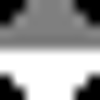
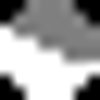
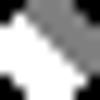
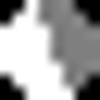
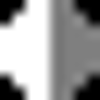
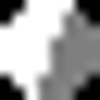
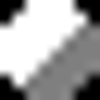
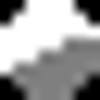
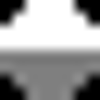
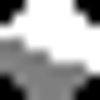
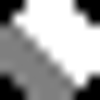
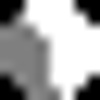
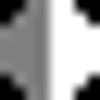
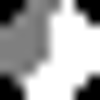
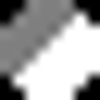
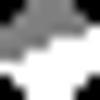

In [9]:
SENSOR_GROUPS_IMG = defaultdict(list) # key - sensor receptive field size, value - list of sensor images
captions = defaultdict(list)
sz = config.sample_size

for receptive_field_size in SENSOR_RECEPTIVE_FIELD_SIZES:
    for sensor_no in range(SENSOR_GROUP_SQUARE):
        canvas = Image.new('L', (sz, sz))
        draw = ImageDraw.Draw(canvas)
        
        if config.encoding_type in ['normal', 'exnormal', 'vector']:
            draw.ellipse([0, 0, receptive_field_size - 1, receptive_field_size - 1], outline=0, fill=127, width=0)
            angle = sensor_no * 360 / SENSOR_GROUP_SQUARE
            draw.chord([0, 0, receptive_field_size - 1, receptive_field_size - 1], angle, angle + 180, outline=255, fill=255)
        elif config.encoding_type == 'onoff':
            sensor_receptive_field_size = receptive_field_size // SENSOR_GROUP_SIZE
            rect_top_x = int(sensor_no % SENSOR_GROUP_SIZE) * sensor_receptive_field_size
            rect_top_y = int(sensor_no // SENSOR_GROUP_SIZE) * sensor_receptive_field_size
            draw.rectangle([rect_top_x, rect_top_y, rect_top_x + sensor_receptive_field_size - 1, rect_top_y + sensor_receptive_field_size - 1], fill=255)
        else:
            assert False, config.encoding_type
        
        captions[receptive_field_size].append(f'#{sensor_no} ({sensor_no // SENSOR_GROUP_SIZE}, {sensor_no % SENSOR_GROUP_SIZE})')
        SENSOR_GROUPS_IMG[receptive_field_size].append(canvas)

first_size = SENSOR_RECEPTIVE_FIELD_SIZES[0]
first_image_list = SENSOR_GROUPS_IMG[first_size]
first_caption_list = captions[first_size]
display_images_grid(list(map(lambda x: x.crop([0,0,first_size,first_size]).resize((100, 100)), first_image_list)), 
                    captions=first_caption_list,
                    col_count=SENSOR_GROUP_SIZE)

In [11]:
# Turn grayscale images to numpy arrays with weights which balance positive and negative areas if sensor type is normal
# (for onoff sensors there is no need in balancing though)
SENSOR_GROUPS = np.zeros((len(SENSOR_RECEPTIVE_FIELD_SIZES), SENSOR_GROUP_SQUARE, config.sample_size, config.sample_size), dtype=float)

for i, receptive_field_size in enumerate(SENSOR_RECEPTIVE_FIELD_SIZES):
    assert receptive_field_size in SENSOR_GROUPS_IMG.keys()
    imgs = SENSOR_GROUPS_IMG[receptive_field_size]
    sensor_group_for_this_receptive_field_size = np.array(list(map(np.array, imgs))).astype(float)
    SENSOR_GROUPS[i] = sensor_group_for_this_receptive_field_size

if config.encoding_type in ['normal', 'exnormal', 'vector']:
    shape_save = SENSOR_GROUPS.shape
    SENSOR_GROUPS = SENSOR_GROUPS.reshape(-1, config.sample_size ** 2)
    # Due to rough granularity count of positive pixels and negative may be not eqaul => equalize via weight
    SENSOR_GROUPS[SENSOR_GROUPS==255] = 1
    counts_of_positives = (SENSOR_GROUPS == 1).sum(axis=1)
    counts_of_negatives = (SENSOR_GROUPS == 127).sum(axis=1)
    white_image = np.ones(SENSOR_GROUPS.shape[1])
    
    for i, (p, n) in enumerate(zip(counts_of_positives, counts_of_negatives)):
        assert p > 0, (i, p)
        assert n > 0, (i, n)
        SENSOR_GROUPS[i][SENSOR_GROUPS[i] == 127] = -1 * (p / n)
        v = SENSOR_GROUPS[i] @ white_image
        assert np.isclose(v, 0), v
    
    SENSOR_GROUPS = SENSOR_GROUPS.reshape(shape_save)
elif config.encoding_type == 'onoff':
    # For onoff sensors we are not interested in negative area. So just binarize (turn to 0/1)
    SENSOR_GROUPS[SENSOR_GROUPS > 0] = 1
else:
    assert False, config.encoding_type
    
SENSOR_GROUPS = xp_array_to_gpu(SENSOR_GROUPS)
SENSOR_GROUPS.shape, np.unique_counts(xp_array_from_gpu(SENSOR_GROUPS))

((10, 16, 128, 128),
 UniqueCountsResult(values=array([-1.36363636, -1.34615385, -1.30952381, -1.26086957, -1.25925926,
        -1.25581395, -1.24      , -1.23529412, -1.22413793, -1.2125    ,
        -1.20895522, -1.18811881, -1.18518519, -1.17857143, -1.17391304,
        -1.17142857, -1.16666667, -1.15555556, -1.15384615, -1.15      ,
        -1.14492754, -1.13253012, -1.12765957, -1.1147541 , -1.11320755,
        -1.11111111, -1.10526316, -1.1047619 , -1.08490566, -1.08450704,
        -1.08333333, -1.08235294, -1.08      , -1.07407407, -1.06382979,
        -1.05405405, -1.04761905, -1.0462963 , -1.03636364, -1.03448276,
        -1.03333333, -1.02739726, -1.02020202, -1.        ,  0.        ,
         1.        ]), counts=array([     44,     104,      84,     138,     162,     172,     100,
             68,     348,     160,     134,     202,     324,     112,
            184,     210,     456,     360,     208,     240,     276,
            332,     376,     244,     106,      72,  

In [12]:
SENSOR_GROUP_AREAS = (SENSOR_GROUPS.reshape(SENSOR_GROUPS.shape[0], SENSOR_GROUPS.shape[1], -1) == 1).sum(axis=2) # number of ON pixels for each receptor (sensor)
SENSOR_GROUP_AREAS.shape, SENSOR_GROUP_AREAS, SENSOR_GROUP_AREAS.mean(), SENSOR_GROUP_AREAS.min(), SENSOR_GROUP_AREAS.max(), SENSOR_GROUP_AREAS.std()

((10, 16),
 array([[ 26,  27,  29,  28,  26,  28,  29,  27,  26,  29,  29,  30,  26,
          30,  29,  29],
        [ 35,  31,  34,  33,  35,  33,  34,  31,  35,  33,  34,  34,  35,
          34,  34,  33],
        [ 38,  39,  41,  40,  38,  40,  41,  39,  38,  41,  41,  42,  38,
          42,  41,  41],
        [ 54,  50,  52,  52,  54,  52,  52,  50,  54,  52,  52,  55,  54,
          55,  52,  52],
        [ 56,  57,  60,  58,  56,  58,  60,  57,  56,  59,  60,  62,  56,
          62,  60,  59],
        [ 71,  66,  69,  68,  71,  68,  69,  66,  71,  68,  69,  71,  71,
          71,  69,  68],
        [ 74,  75,  79,  77,  74,  77,  79,  75,  74,  77,  79,  81,  74,
          81,  79,  77],
        [ 96,  90,  94,  92,  96,  92,  94,  90,  96,  92,  94,  97,  96,
          97,  94,  92],
        [100, 101, 106, 104, 100, 104, 106, 101, 100, 105, 106, 108, 100,
         108, 106, 105],
        [119, 113, 116, 115, 119, 115, 116, 113, 119, 115, 116, 120, 119,
         120, 116, 115]]

# Retina and layout cortical columns

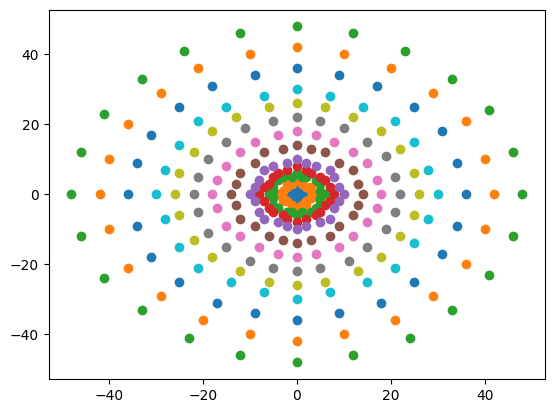

In [13]:
radiuses = [2, 4, 6, 8, 10, 14, 18, 22, 26, 30, 36, 42, 48]
rotations = 24
rotation_transfs = []

for i in range(rotations):
    theta = (2 * math.pi / rotations) * i
    cos_theta = math.cos(theta)
    sin_theta = math.sin(theta)
    transf = [
        [cos_theta, sin_theta, 0],
        [-sin_theta, cos_theta, 0],
        [0, 0, 1]
    ]
    rotation_transfs.append(np.array(transf))

rotation_transfs = np.array(rotation_transfs)

for radius in radiuses:
    arrow = np.array([radius, 0, 0])
    arrow_positions = (rotation_transfs @ arrow).astype(int)
    arrow_positions = set([(ap[0], ap[1]) for ap in arrow_positions])
    arrow_positions = list(arrow_positions)
    xs = list(map(lambda ap: ap[0], arrow_positions))
    ys = list(map(lambda ap: ap[1], arrow_positions))
    plt.scatter(xs, ys)

plt.show()

In [43]:
class SensorGroupDistributor(object):
    def __call__(self, sensor_group_index):
        return None

class SensorGroupDistributor_Grid(SensorGroupDistributor):
    def __init__(self):
        self.s = SENSOR_GROUPS_ROOT
        self.field_size_index = 0
        self.field_size = SENSOR_RECEPTIVE_FIELD_SIZES[self.field_size_index]
        space_for_groups = self.s * self.field_size 
        self.dist_between_groups = (config.sample_size - space_for_groups) / (self.s - 1)
        
    def __call__(self, sensor_group_index):
        x = int((sensor_group_index % self.s) * (self.field_size + self.dist_between_groups))
        y = int((sensor_group_index // self.s) * (self.field_size + self.dist_between_groups))
        # adjust to fit into boundaries
        x -= max(0, (x + self.field_size) - config.sample_size) 
        y -= max(0, (y + self.field_size) - config.sample_size)
        return x, y, self.field_size, self.field_size_index

class SensorGroupDistributor_ConcentricCircles(SensorGroupDistributor):
    def __init__(self):
        self.half_sample_size = config.sample_size // 2
        radiuses = list(range(6, 112, 6))
        rotations = 24 #36
        rotation_transfs = []
        
        for i in range(rotations):
            theta = (2 * math.pi / rotations) * i
            cos_theta = math.cos(theta)
            sin_theta = math.sin(theta)
            transf = [
                [cos_theta, sin_theta, 0],
                [-sin_theta, cos_theta, 0],
                [0, 0, 1]
            ]
            rotation_transfs.append(np.array(transf))
        
        rotation_transfs = np.array(rotation_transfs)
        self.points = []
        self.field_size_indices = [] 
        
        for radius_index, radius in enumerate(radiuses):
            arrow = np.array([radius, 0, 0])
            arrow_positions = (rotation_transfs @ arrow).astype(int)
            arrow_positions += self.half_sample_size
            arrow_positions = set([(ap[0], ap[1]) for ap in arrow_positions])
            self.points.extend(list(arrow_positions))
            field_size = int(len(SENSOR_RECEPTIVE_FIELD_SIZES) * radius_index / len(radiuses))
            self.field_size_indices.extend([field_size] * len(arrow_positions))

        assert len(self.field_size_indices) == len(self.points)
        assert len(self.field_size_indices) >= SENSOR_GROUPS_COUNT, (len(self.field_size_indices), SENSOR_GROUPS_COUNT)
        
    def __call__(self, sensor_group_index):
        field_size_index = self.field_size_indices[sensor_group_index]
        field_size = SENSOR_RECEPTIVE_FIELD_SIZES[field_size_index]
        x, y = self.points[sensor_group_index]
        x_offset = x - field_size // 2
        y_offset = y - field_size // 2
        x_offset = max(0, min(x_offset, config.sample_size - field_size - 1))
        y_offset = max(0, min(y_offset, config.sample_size - field_size - 1))
        return x_offset, y_offset, field_size, field_size_index

class SensorGroupDistributor_2d_Gauss(SensorGroupDistributor):
    def __init__(self):
        self.half_sample_size = config.sample_size // 2
        self.max_radius = np.linalg.norm((self.half_sample_size, self.half_sample_size)) # max distance from center to corner
        self.mean = [0, 0]
        self.cov = [[self.half_sample_size, 0], [0, self.half_sample_size]]  # spherical covariance
        self.unique_xy_pairs = set()
        
    def __call__(self, sensor_group_index):
        for _ in range(10000):
            x, y = np.random.multivariate_normal(self.mean, self.cov, 1).T * 4
            x = int(x[0])
            y = int(y[0])
    
            if x < -self.half_sample_size or x >= self.half_sample_size or y < -self.half_sample_size or y >= self.half_sample_size:
                continue
    
            point_radius = np.linalg.norm((x, y))
            x = x + self.half_sample_size
            y = y + self.half_sample_size
            assert x >= 0 and x < config.sample_size
            assert y >= 0 and y < config.sample_size
            assert point_radius <= self.max_radius
    
            # field_size_index = 0
            field_size_index = int(len(SENSOR_RECEPTIVE_FIELD_SIZES) * point_radius / self.max_radius)
            assert field_size_index >= 0 and field_size_index < len(SENSOR_RECEPTIVE_FIELD_SIZES)
    
            field_size = SENSOR_RECEPTIVE_FIELD_SIZES[field_size_index]
            radius = field_size // 2
            
            if x > config.sample_size - radius or x < radius:
                continue
    
            if y > config.sample_size - radius or y < radius:
                continue
    
            if (x, y) in self.unique_xy_pairs:
                continue
    
            self.unique_xy_pairs.add((x, y))
            return x - radius, y - radius, field_size, field_size_index
        else:
            assert False, 'Failed to draw suitable x, y, radius within given attempts'

In [44]:
SENSOR_GROUP_DISTRIBUTOR = None

match config.retina_layout:
    case 'grid': 
        SENSOR_GROUP_DISTRIBUTOR = SensorGroupDistributor_Grid()
    case '2d_gauss':
        SENSOR_GROUP_DISTRIBUTOR = SensorGroupDistributor_2d_Gauss()
    case 'concentric_circles':
        SENSOR_GROUP_DISTRIBUTOR = SensorGroupDistributor_ConcentricCircles()
    case _:
        assert False, config.retina_layout

In [45]:
assert not SENSOR_GROUP_DISTRIBUTOR is None
RETINA_SENSOR_GROUP_INFOS = pd.DataFrame(columns=['group_index', 'field_size_index', 'x_offset', 'y_offset', 'receptive_field_size', 'x_center', 'y_center', 'radius'])
retina = xp.zeros((SENSOR_GROUPS_COUNT, SENSOR_GROUP_SQUARE, config.sample_size, config.sample_size))

for i in range(SENSOR_GROUPS_COUNT):
    x_offset, y_offset, field_size, field_size_index = SENSOR_GROUP_DISTRIBUTOR(i)
    assert x_offset >= 0 and x_offset <= config.sample_size - field_size, (i, x_offset, field_size)
    assert y_offset >= 0 and y_offset <= config.sample_size - field_size, (i, y_offset, field_size)
    
    for g in range(SENSOR_GROUP_SQUARE):
        receptor_plane = retina[i, g]
        assert y_offset <= receptor_plane.shape[0] - field_size, (y_offset, receptor_plane.shape[0], field_size) # make sure we don't roll too much
        assert x_offset <= receptor_plane.shape[1] - field_size, (x_offset, receptor_plane.shape[1], field_size) # with points wrapped around axes
        sensor_at_place = SENSOR_GROUPS[field_size_index, g]
        sensor_at_place = xp.roll(sensor_at_place, y_offset, axis=0)
        sensor_at_place = xp.roll(sensor_at_place, x_offset, axis=1)
        receptor_plane[:] = sensor_at_place
        
    RETINA_SENSOR_GROUP_INFOS.loc[len(RETINA_SENSOR_GROUP_INFOS)] = [
        i, # index_within_retina
        field_size_index,
        x_offset,
        y_offset,
        field_size,
        x_offset + field_size // 2,
        y_offset + field_size // 2,
        field_size // 2
    ]

RETINA_COMBINED = retina.reshape((-1, config.sample_size ** 2))
RETINA_POS = RETINA_COMBINED.copy()
RETINA_NEG = RETINA_COMBINED.copy()

RETINA_POS[RETINA_POS < 0] = 0
RETINA_NEG[RETINA_NEG > 0] = 0

RETINA_SENSOR_GROUP_AREAS = xp.zeros((SENSOR_GROUPS_COUNT, SENSOR_GROUP_SQUARE))

for _, sensor_group_info in RETINA_SENSOR_GROUP_INFOS.iterrows():
    sensor_group_index = sensor_group_info['group_index']
    field_size_index = sensor_group_info['field_size_index']
    RETINA_SENSOR_GROUP_AREAS[sensor_group_index] = SENSOR_GROUP_AREAS[field_size_index]

RETINA_SENSOR_GROUP_INFOS

,group_index,field_size_index,x_offset,y_offset,receptive_field_size,x_center,y_center,radius
0,0,0,0,0,8,4,4,4
1,1,0,3,0,8,7,4,4
2,2,0,7,0,8,11,4,4
3,3,0,11,0,8,15,4,4
4,4,0,15,0,8,19,4,4
...,...,...,...,...,...,...,...,...
1019,1019,0,104,120,8,108,124,4
1020,1020,0,108,120,8,112,124,4
1021,1021,0,112,120,8,116,124,4
1022,1022,0,116,120,8,120,124,4


In [46]:
assert config.cortical_columns_layout in ['random', 'radial']
CORTICAL_COLUMN_RECEPTIVE_FIELDS = np.zeros((config.cortical_columns_count, SENSORS_COUNT), dtype='b') # aka masks for encoding vectors
CORTICAL_COLUMN_RECEPTIVE_FIELDS_INFO = pd.DataFrame(columns=['column_id', 'x_center', 'y_center', 'radius', 'sensor_group_indices'])

In [47]:
if config.cortical_columns_layout == 'random':
    # Random groups pickup without any viscinity radiuses
    CORTICAL_COLUMN_RECEPTIVE_FIELDS[:] = 0
    CORTICAL_COLUMN_RECEPTIVE_FIELDS_INFO = pd.DataFrame(columns=CORTICAL_COLUMN_RECEPTIVE_FIELDS_INFO.columns)
    
    for column_id in range(config.cortical_columns_count):
        sensor_group_indices = np.sort(RNG.choice(SENSOR_GROUPS_COUNT, config.cortical_column_receptive_field_size, replace=False))
        CORTICAL_COLUMN_RECEPTIVE_FIELDS_INFO.loc[len(CORTICAL_COLUMN_RECEPTIVE_FIELDS_INFO)] = [column_id, -1, -1, -1, sensor_group_indices]
    
        for group_index in sensor_group_indices:
            sensor_group_index_lo = group_index * SENSOR_GROUP_SQUARE
            sensor_group_index_hi = sensor_group_index_lo + SENSOR_GROUP_SQUARE
            CORTICAL_COLUMN_RECEPTIVE_FIELDS[column_id][sensor_group_index_lo:sensor_group_index_hi] = 1
    
    CORTICAL_COLUMN_RECEPTIVE_FIELDS_INFO

In [48]:
if config.cortical_columns_layout == 'radial':
    # Column receptive field is a group of sensors within given radius
    CORTICAL_COLUMN_RECEPTIVE_FIELDS[:] = 0
    CORTICAL_COLUMN_RECEPTIVE_FIELDS_INFO = pd.DataFrame(columns=CORTICAL_COLUMN_RECEPTIVE_FIELDS_INFO.columns)
    
    cortical_column_receptive_field_radius = config.cortical_column_receptive_field_size
    half_sample_size = config.sample_size // 2
    centers = [(0, 0)]
    rotations = 360 // 36
    rotation_transfs = []
    
    for i in range(rotations):
        theta = (2 * math.pi / rotations) * i
        cos_theta = math.cos(theta)
        sin_theta = math.sin(theta)
        transf = [
            [cos_theta, sin_theta, 0],
            [-sin_theta, cos_theta, 0],
            [0, 0, 1]
        ]
        rotation_transfs.append(np.array(transf))
    
    rotation_transfs = np.array(rotation_transfs)
    
    for column_id in range(config.cortical_columns_count):
        center_x, center_y = centers.pop(0)
        arrow = np.array([cortical_column_receptive_field_radius, 0, 0])
        arrow_positions = (rotation_transfs @ arrow).astype(int)
        arrow_positions = set([(ap[0], ap[1]) for ap in arrow_positions])
        centers.extend(arrow_positions) # push to the end
        
        center_x = max(0, min(center_x + half_sample_size, config.sample_size - 1))
        center_y = max(0, min(center_y + half_sample_size, config.sample_size - 1))
        
        sensor_group_indices = []
    
        for _, sensor_group_info in RETINA_SENSOR_GROUP_INFOS.iterrows():
            group_receptive_field_size = sensor_group_info['receptive_field_size']
            group_x_center = sensor_group_info['x_offset'] + group_receptive_field_size // 2
            group_y_center = sensor_group_info['y_offset'] + group_receptive_field_size // 2
            group_x_center_column_pov = group_x_center - center_x
            group_y_center_column_pov = group_y_center - center_y
            dist = np.linalg.norm((group_x_center_column_pov, group_y_center_column_pov))
    
            if dist <= cortical_column_receptive_field_radius:
                group_index = sensor_group_info['group_index']
                sensor_group_index_lo = group_index * SENSOR_GROUP_SQUARE
                sensor_group_index_hi = sensor_group_index_lo + SENSOR_GROUP_SQUARE
                CORTICAL_COLUMN_RECEPTIVE_FIELDS[column_id][sensor_group_index_lo:sensor_group_index_hi] = 1
                sensor_group_indices.append(group_index)
    
        CORTICAL_COLUMN_RECEPTIVE_FIELDS_INFO.loc[len(CORTICAL_COLUMN_RECEPTIVE_FIELDS_INFO)] = \
        [column_id, center_x, center_y, cortical_column_receptive_field_radius, sensor_group_indices]
    
CORTICAL_COLUMN_RECEPTIVE_FIELDS_INFO

,column_id,x_center,y_center,radius,sensor_group_indices


CPU times: user 310 ms, sys: 48.4 ms, total: 358 ms
Wall time: 356 ms


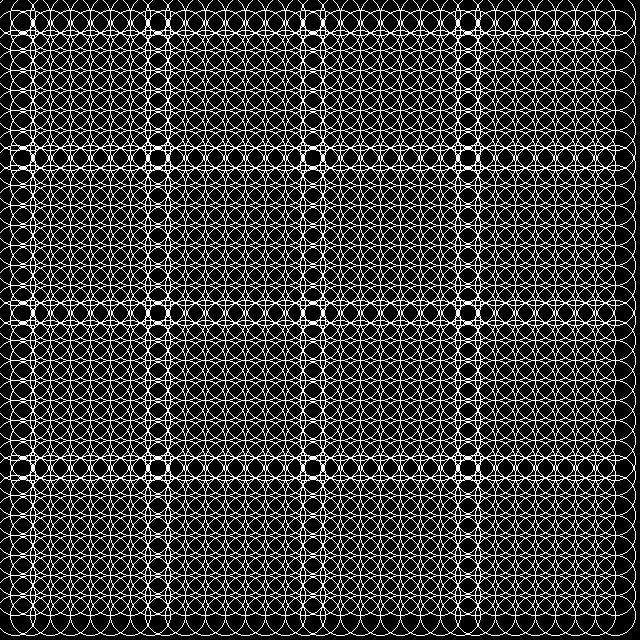

In [49]:
%%time
df_centers = pd.DataFrame(columns=['x', 'y'])
sz = int(np.sqrt(RETINA_COMBINED.shape[1]))
assert sz * sz == RETINA_COMBINED.shape[1]
k = 5
retina_map = Image.new('RGBA', (sz * k, sz * k), color='black')
retina_map_draw = ImageDraw.Draw(retina_map)
sensor_group_locs = np.array(RETINA_SENSOR_GROUP_INFOS[['x_center', 'y_center']])
retina_combined_host = xp_array_from_gpu(RETINA_COMBINED)
cortical_coloumn_chip_color_map = mpl.colormaps['tab20']
cortical_coloumn_chip_offsets = np.random.multivariate_normal([0, 0], [[4, 0], [0, 4]], config.cortical_columns_count).astype(int)

# step = 1 # Checking each sensor (receptor)
step = SENSOR_GROUP_SQUARE # Checking each sensor group

for i in range(0, retina_combined_host.shape[0], step):
    receptor_plane = retina_combined_host[i]
    receptor_plane = receptor_plane.reshape((sz, sz))
    receptor_plane *= receptor_plane # get rid of -1 
    vert = np.argwhere(receptor_plane.sum(axis=1) != 0).ravel() # project non-zero pixels on Y axis and get indices where they land
    horz = np.argwhere(receptor_plane.sum(axis=0) != 0).ravel() # project non-zero pixels on X axis and get indices where they land
    vert_lo = vert[0]
    vert_hi = vert[-1]
    horz_lo = horz[0]
    horz_hi = horz[-1]
    center_x = int((horz_lo + horz_hi) / 2)
    center_y = int((vert_lo + vert_hi) / 2)
    radius = int(max((vert_hi - vert_lo + 1), (horz_hi - horz_lo + 1)) / 2)
    cortical_column_chips_to_draw = []

    if config.encoding_type in ['normal', 'exnormal'] and config.cortical_columns_count > 0:
        # Reverse check that discovered bulge on retina corresponds to a sensor group
        center_x_sensor_group_povs = center_x - sensor_group_locs[:,0]
        center_y_sensor_group_povs = center_y - sensor_group_locs[:,1]
        dist_from_sensor_group_centers = np.linalg.norm(np.vstack([center_x_sensor_group_povs, center_y_sensor_group_povs]).T, axis=1)
        assert dist_from_sensor_group_centers.shape == (SENSOR_GROUPS_COUNT,)
        closest_group_index = np.argmin(dist_from_sensor_group_centers)
    
        group_info = RETINA_SENSOR_GROUP_INFOS[RETINA_SENSOR_GROUP_INFOS['group_index'] == closest_group_index].iloc[0]
        assert np.linalg.norm((center_x - group_info['x_center'], center_y - group_info['y_center'])) <= group_info['radius']
    
        # Check that corresponding sensor group is within CORTICAL_COLUMN_RECEPTIVE_FIELDS
        necessary_stride_within_cort_column_receptive_fields = np.zeros(SENSORS_COUNT, dtype='b')
        necessary_stride_within_cort_column_receptive_fields[closest_group_index * SENSOR_GROUP_SQUARE:(closest_group_index+1) * SENSOR_GROUP_SQUARE] = 1
        necessary_stride_within_cort_column_receptive_fields_ones = (necessary_stride_within_cort_column_receptive_fields == 1).sum()
    
        for _, cortical_column_receptive_field_info in CORTICAL_COLUMN_RECEPTIVE_FIELDS_INFO.iterrows():
            column_id = cortical_column_receptive_field_info['column_id']
            cortical_column_group_indices = cortical_column_receptive_field_info['sensor_group_indices']
            cortical_column_receptive_field = CORTICAL_COLUMN_RECEPTIVE_FIELDS[column_id]
            scalar_prod = necessary_stride_within_cort_column_receptive_fields @ cortical_column_receptive_field
            
            if np.any(cortical_column_group_indices == closest_group_index):
                # discovered bulde (sensor group) is accounted for this column. Check that receptive field of this column (mask)
                # is aligned with this statement
                assert scalar_prod == necessary_stride_within_cort_column_receptive_fields_ones
                chip_color = cortical_coloumn_chip_color_map(column_id % cortical_coloumn_chip_color_map.N, bytes=True)
                chip_offsets = cortical_coloumn_chip_offsets[column_id]
                cortical_column_chips_to_draw.append((chip_offsets[0], chip_offsets[1], chip_color))
            else:
                # discovered bulde (sensor group) is NOT accounted for this column. Check that receptive field of this column (mask)
                # is aligned with this statement
                assert scalar_prod == 0

    center_x = k * center_x
    center_y = k * center_y
    radius = k * radius
    assert radius <= 100, radius
    retina_map_draw.circle((center_x, center_y), radius, width=1, outline=200)

    for chip_to_draw in cortical_column_chips_to_draw:
        retina_map_draw.circle((center_x + chip_to_draw[0], center_y + chip_to_draw[1]), radius / 3, outline=chip_to_draw[2], fill=chip_to_draw[2])
    
    df_centers.loc[len(df_centers)] = [center_x, center_y]

if config.cortical_columns_layout == 'radial':
    for _, cortical_column_receptive_field_info in CORTICAL_COLUMN_RECEPTIVE_FIELDS_INFO.iterrows():
        column_id = cortical_column_receptive_field_info['column_id']
        column_x_center = cortical_column_receptive_field_info['x_center']
        column_y_center = cortical_column_receptive_field_info['y_center']
        column_radius = cortical_column_receptive_field_info['radius']
        column_color = cortical_coloumn_chip_color_map(column_id % cortical_coloumn_chip_color_map.N, bytes=True)
        retina_map_draw.circle((column_x_center * k, column_y_center * k), column_radius * k, outline=column_color, width=3)

retina_map

# sense_images

In [51]:
MINIMAL_ILLUMINATION_ABS_LEVEL = 255 * 0.1
MINIMAL_ILLUMINATION_DIFF_DB = 2 # dB
MINIMAL_ILLUMINATION_DIFF_RATIO = pow(10, MINIMAL_ILLUMINATION_DIFF_DB/20)

def sense_images_normal(images):
    sense_ress = []
    image_masks = images.copy()
    image_masks[image_masks > 0] = 1

    sense_area = (RETINA_POS @ image_masks.T).T # for check of illuminated area (number of illuminated pixels)
    sense_level = (RETINA_POS @ images.T).T # for check of absolute illumination
    sense_neg_level = (RETINA_NEG @ images.T).T # for check of relative diff

    assert sense_area.shape == (len(images), SENSOR_GROUPS_COUNT * SENSOR_GROUP_SQUARE), sense_area.shape
    assert sense_area.shape == sense_level.shape
    assert sense_area.shape == sense_neg_level.shape
    
    # Base for calculations = AREA of illumination must be at least 1/2 of area of positive receptors
    # Next we exclude sensors which do not minimal LEVEL of illumination = area * (255 * 10%)
    # Finally we exclude sensors which do not have enough contrast (DIFF) - use NEG part of retina and use logarithmic scale (dB)
    for sense_area_i, sense_level_i, sense_neg_level_i in zip(sense_area, sense_level, sense_neg_level):
        # Per image cycle
        # sense_area_i is a matrix: row=sensor group, column=number of illuminated pixels for each receptor in this group
        sense_area_i = sense_area_i.reshape(-1, SENSOR_GROUP_SQUARE)  
        cond1 = (sense_area_i / RETINA_SENSOR_GROUP_AREAS) >= 0.5 # At least half of a positive area of each of sensors is activated
        cond1 = cond1.reshape(-1,)

        # sense_level_i is a matrix: row=sensor group, column=sum of illimination on positive part of each receptor
        sense_level_i = sense_level_i.reshape(-1, SENSOR_GROUP_SQUARE)
        sense_level_i[sense_level_i <= 0] = 1e-6 # to ease cond3
        cond2 = (sense_level_i > MINIMAL_ILLUMINATION_ABS_LEVEL * RETINA_SENSOR_GROUP_AREAS) # Illumination level of an area must exceed given threshold
        cond2 = cond2.reshape(-1,)

        # sense_neg_level_i is a matrix: row=sensor group, column=sum of illimination on negative part of each receptor
        sense_neg_level_i = xp.abs(sense_neg_level_i)
        sense_neg_level_i[sense_neg_level_i <= 0] = 1e-6 # to ease cond3
        cond3 = (sense_level_i.reshape(-1,) / sense_neg_level_i) >= MINIMAL_ILLUMINATION_DIFF_RATIO # Illumination of positive area must be > illumination of negative one
    
        sense_res = (cond1 & cond2 & cond3).astype(int) # mask of active sensors for particular image
        sense_ress.append(sense_res)

    return xp.array(sense_ress)

def sense_images_onoff(images):
    sense_ress = []

    sense_level = (RETINA_POS @ images.T).T # for check of absolute illumination
    assert sense_level.shape == (len(images), SENSOR_GROUPS_COUNT * SENSOR_GROUP_SQUARE), sense_level.shape

    # Check that integral illumination of sensor surface exceeds threshold (255 * area / 2)
    for sense_level_i in sense_level:
        # Per image cycle
        # sense_level_i is a matrix: row=sensor group, column=sum of illimination on surface of each receptor
        sense_level_i = sense_level_i.reshape(-1, SENSOR_GROUP_SQUARE)
        cond = (sense_level_i > 255 * RETINA_SENSOR_GROUP_AREAS / 2) # Illumination level of an area must exceed given threshold
        cond = cond.reshape(-1,)

        sense_res = cond.astype(int) # mask of active sensors for particular image
        sense_ress.append(sense_res)

    return xp.array(sense_ress)

match config.encoding_type:
    case 'normal' | 'exnormal' | 'vector': sense_images = sense_images_normal
    case 'onoff': sense_images = sense_images_onoff
    case _: assert False, config.encoding_type

# Specific samples


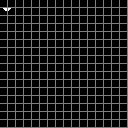
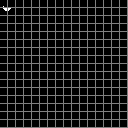
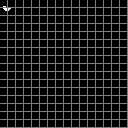
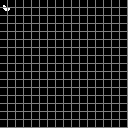
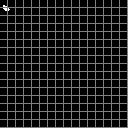
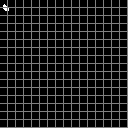
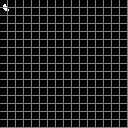
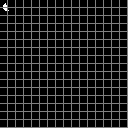
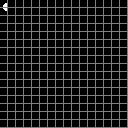
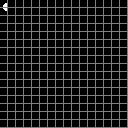
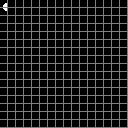
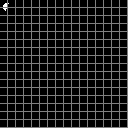
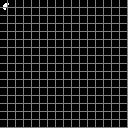
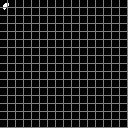
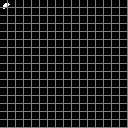
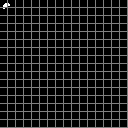
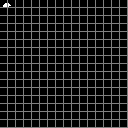
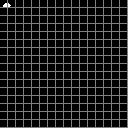
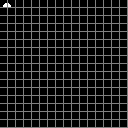
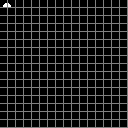
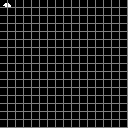
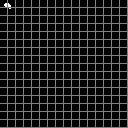
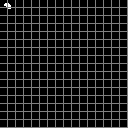
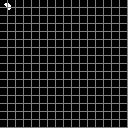
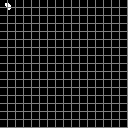

In [53]:
# For each sensor group we prepare bunch of specific samples (measured in steps here)
SPECIFIC_SAMPLES_IMG = defaultdict(list) # key - index of sensor group, value - list of specific images for this sensor group
SPECIFIC_SAMPLES_IMG_TO_NORMAL = dict() # key - index of specific image, value - normal (angle) in form of complex number
sz = config.sample_size

for _, sensor_group_info in RETINA_SENSOR_GROUP_INFOS.iterrows():
    sensor_group_index = sensor_group_info['group_index']
    x_offset = sensor_group_info['x_offset'] # where sensor group
    y_offset = sensor_group_info['y_offset'] # is located on retina
    receptive_field_size = sensor_group_info['receptive_field_size']
    
    if config.encoding_type in ['normal', 'exnormal', 'vector']:
        steps = 360 // 10
        angle_per_step = 360 // steps
        assert steps * angle_per_step == 360, steps * angle_per_step
        
        for i in range(steps):
            canvas = Image.new('L', (sz, sz))
            draw = ImageDraw.Draw(canvas)
            # In ImageDraw angles are measured from 3 o’clock, increasing clockwise.
            angle = i * angle_per_step
            draw.chord([x_offset, y_offset, x_offset + receptive_field_size - 1, y_offset + receptive_field_size - 1], angle, angle + 180, outline=255, fill=255)
            SPECIFIC_SAMPLES_IMG[sensor_group_index].append(canvas)
            # remember a perpendicular to current angle with respect to a straight surface of a chord - this gonna be our normal
            angle_ccw = (360 - angle)
            normal_angle_ccw = (angle_ccw + 90) % 360
            normal_complex = np.exp((1j) * np.radians(normal_angle_ccw))
            SPECIFIC_SAMPLES_IMG_TO_NORMAL[i] = normal_complex
            assert np.isclose(np.angle(normal_complex, deg=True) % 360, normal_angle_ccw)
    elif config.encoding_type == 'onoff':
        for y in range(1, receptive_field_size + 1, 2):
            for x in range(1, receptive_field_size + 1, 2):
                for radius in range(2, receptive_field_size):
                    canvas = Image.new('L', (sz, sz))
                    draw = ImageDraw.Draw(canvas)
                    center_x = x_offset + x
                    center_y = y_offset + y
                    draw.circle([center_x, center_y], radius, fill=255)
                    draw.rectangle([-1, -1, x_offset, sz], fill=0)
                    draw.rectangle([-1, -1, sz, y_offset], fill=0)
                    draw.rectangle([x_offset + receptive_field_size, -1, sz, sz], fill=0)
                    draw.rectangle([-1, y_offset + receptive_field_size, sz, sz], fill=0)

                    if np.array(canvas).sum() > 0:
                        SPECIFIC_SAMPLES_IMG[sensor_group_index].append(canvas)
    else:
        assert False, config.encoding_type

sensor_group_index_to_show = RNG.choice(list(SPECIFIC_SAMPLES_IMG.keys()))
images_to_show = SPECIFIC_SAMPLES_IMG[sensor_group_index_to_show][:25]
captions = list(map(lambda i: f'normal={np.round(np.angle(SPECIFIC_SAMPLES_IMG_TO_NORMAL.get(i[0], 0j), deg=True), decimals=0):.0f}', enumerate(images_to_show)))
display_images_grid(list(map(lambda x: lay_grid(x, 8), images_to_show)), captions=captions, col_count=5)

In [54]:
SPECIFIC_SAMPLES_ENCODINGS = dict()

# matrix (360, SENSOR_GROUP_SQUARE). Each row corresponds to an angle.
# Hamming dist can be used to find nearest angle
SENSOR_GROUP_NORMALS = defaultdict(lambda: np.zeros((360, SENSOR_GROUP_SQUARE), dtype='b')) 

for sensor_group_index, specific_samples_img in tqdm(SPECIFIC_SAMPLES_IMG.items()):
    specific_samples_img = xp.array(specific_samples_img)
    specific_samples_img = specific_samples_img.reshape(specific_samples_img.shape[0], -1)
    encodings = xp_array_from_gpu(sense_images(specific_samples_img))
    SPECIFIC_SAMPLES_ENCODINGS[sensor_group_index] = np.array(encodings)
    
    sensor_group_normals = SENSOR_GROUP_NORMALS[sensor_group_index]

    for specific_sample_img_index, encoding in enumerate(encodings):
        normal = SPECIFIC_SAMPLES_IMG_TO_NORMAL[specific_sample_img_index]
        angle = np.round(np.angle(normal, deg=True), decimals=0)
        angle = int(angle) % 360 # here we may have angle from -180 to +180, turn to 0-360
        assert angle >= 0 and angle < 360
        sensor_vector = encoding[sensor_group_index * SENSOR_GROUP_SQUARE:(sensor_group_index + 1) * SENSOR_GROUP_SQUARE]
        sensor_group_normals[angle] = sensor_vector

    # Interpolate missing values
    angles = np.argwhere(sensor_group_normals.sum(axis=1) > 0).ravel()
    
    for angle in range(360):
        if np.any(sensor_group_normals[angle] > 0):
            continue
        
        diffs = np.abs(angles - angle)
        nearest_angle_index = np.argmin(diffs)
        nearest_angle = angles[nearest_angle_index]
        nearest_sensor_vector = sensor_group_normals[nearest_angle]
        sensor_group_normals[angle] = nearest_sensor_vector

SPECIFIC_SAMPLES_ENCODINGS[0].shape

  0%|          | 0/1024 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [77]:
N = 400_000_000
list_N = []
list_M = []

while len(list_N) < 5:
    M = []
    
    for i in range(2, N):
        if (N % i) == 0:
            M.append(i)

            if len(M) >= 5:
                break

    if len(M) >= 5:
        M = M[0] * M[1] * M[2] * M[3] * M[4]
    else:
        M = 0

    if M > 0 and M < N:
        list_N.append(N)
        list_M.append(M)

    N += 1

print(list_M[-1])

1152


In [76]:
list_N

[400000000, 400000004, 400000005, 400000006, 400000008]

In [66]:
x = M[0] * M[1] * M[2] * M[3] * M[4]

In [67]:
x > 0 and x < N

True

In [68]:
list_N

[]

# Normals

In [22]:
NORMAL_RADIUS = 4
ANGLE_TO_COMLEX = {} # key - angle (0-359), value - correspondings complex number

In [23]:
for angle in range(360):
    ANGLE_TO_COMLEX[angle] = np.exp((1j) * np.radians(angle))

In [24]:
def angle_to_complex(angle):
    angle = int(angle) % 360
    return ANGLE_TO_COMLEX[angle]

In [25]:
ENDPOINT_TO_RAYS_INDEX = defaultdict(set)
RAYS = []
rays_set = set()
path = np.vstack([np.arange(0, NORMAL_RADIUS + 1), np.zeros((2, NORMAL_RADIUS + 1))]).T # list of points from center to periphery

for i in range(360):
    theta = math.radians(i)
    cos_theta = math.cos(theta)
    sin_theta = math.sin(theta)
    transf = [
        [cos_theta, sin_theta, 0],
        [-sin_theta, cos_theta, 0],
        [0, 0, 1]
    ]
    rotated_path = np.round(transf @ path.T, decimals=0).astype(int)
    ray = tuple(zip(rotated_path[0], rotated_path[1]))

    if not ray in rays_set:
        rays_set.add(ray)
        RAYS.append(ray)

for ray_index, ray in enumerate(RAYS):
    for point in ray:
        if point != (0, 0):
            ENDPOINT_TO_RAYS_INDEX[(point)].add(ray)

ENDPOINT_TO_RAYS_INDEX.default_factory = None # seal index, prevent accidential insertions

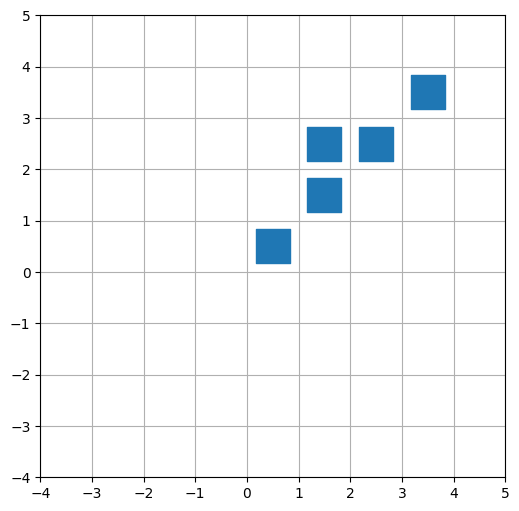

In [26]:
ray_index = 10
ray = np.array(RAYS[ray_index])

plt.figure(figsize=(6,6))
plt.scatter(ray[:,0] + 0.5, -ray[:,1] + 0.5, s=600, marker='s')
plt.ylim(-NORMAL_RADIUS, NORMAL_RADIUS + 1)
plt.xlim(-NORMAL_RADIUS, NORMAL_RADIUS + 1)
plt.grid()
plt.show()

# Image offsets

In [27]:
def get_grid_offsets(lo, hi):
    assert hi > lo
    points = []
    rng = range(lo, hi + 1)
    
    for i in rng:
        for j in rng:
            if i == 0 and j == 0:
                continue
                
            points.append((i,j))
    
    return np.array(points)

def get_clock_offsets(radiuses):
    assert np.all(np.array(radiuses) > 0)
    hours = 12
    rotation_transfs = []
    
    for i in range(hours):
        theta = (2 * math.pi / hours) * i
        cos_theta = math.cos(theta)
        sin_theta = math.sin(theta)
        transf = [
            [cos_theta, sin_theta, 0],
            [-sin_theta, cos_theta, 0],
            [0, 0, 1]
        ]
        rotation_transfs.append(np.array(transf))
    
    rotation_transfs = np.array(rotation_transfs)
    points = dict()
    
    for radius in radiuses:
        arrow = np.array([radius, 0, 0])
        arrow_positions = (rotation_transfs @ arrow).astype(int)
        # duplicates handling
        arrow_positions_codes = [''.join(map(str, ap)) for ap in arrow_positions]
        points.update(zip(arrow_positions_codes, arrow_positions))
    
    if '000' in points: 
        del points['000']

    return np.array(list(points.values()))[:,0:2]

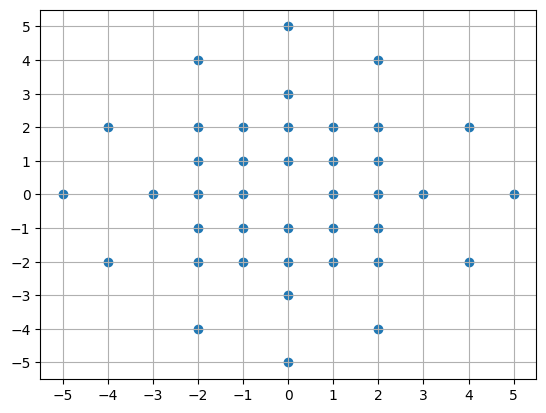

(40, 2)

In [28]:
points1 = get_grid_offsets(-2, 2)
points2 = get_clock_offsets([5, 3])
points = np.array(list(set(map(lambda x: (int(x[0]), int(x[1])), chain(points1, points2)))))
plt.grid()
plt.scatter(points[:,0], points[:,1])
plt.xticks(range(np.max(points) * -1, np.max(points) + 1, 1))
plt.yticks(range(np.max(points) * -1, np.max(points) + 1, 1))
plt.show()
points.shape

In [29]:
def generate_image_offsets(image, offsets):
    sz = int(np.sqrt(image.shape[0]))
    assert sz * sz == image.shape[0]
    images = []

    for off in offsets:
        image_offed = image.reshape(sz, sz)

        # offset by x
        x = off[0]
        image_offed = np.roll(image_offed, x, axis=1)
        cols_to_wipeout = [min(x, 0) + i for i in range(abs(x))]
        image_offed[:,cols_to_wipeout] = 0

        # offset by y
        y = off[1]
        image_offed = np.roll(image_offed, y, axis=0)
        rows_to_wipeout = [min(y, 0) + i for i in range(abs(y))]
        image_offed[rows_to_wipeout,:] = 0
        
        image_offed = image_offed.reshape(-1)
        images.append(image_offed)

    return np.array(images)


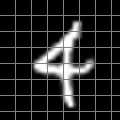
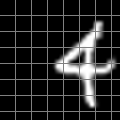
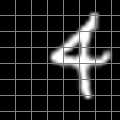
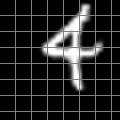
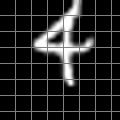
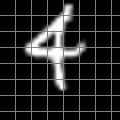
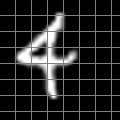
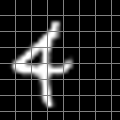
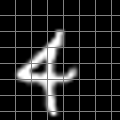
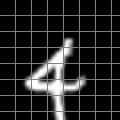
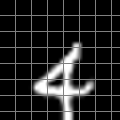
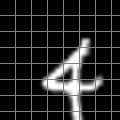
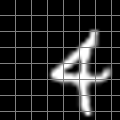
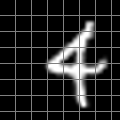
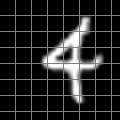
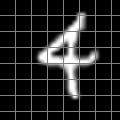
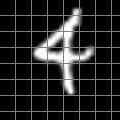
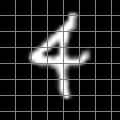
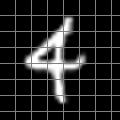
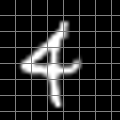
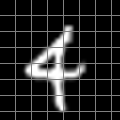
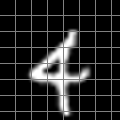
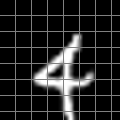
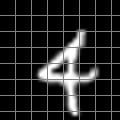
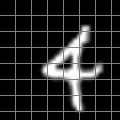
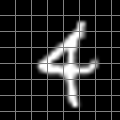
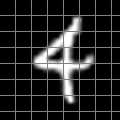
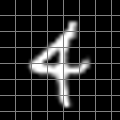
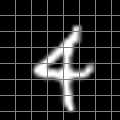

In [30]:
xy_offsets = np.concat([[[0, 0]], get_clock_offsets([5, 3, 1])])
img_data = x_train[RNG.choice(len(x_train))]

with Image.frombytes('L', size=(28, 28), data=img_data) as img:
    image_offsets = generate_image_offsets(np.array(img).ravel(), xy_offsets)

captions = list(map(lambda x: f'x={x[0]}, y={x[1]}', xy_offsets))
display_images_grid(list(map(lambda i: lay_grid(matrix_to_image(i).resize((120, 120)), 16), image_offsets)), captions=captions, col_count=8)

# Table 'stride_hdvs'

In [31]:
%%time
# STRIDE_HDV_TYPE = 'random' # each stride hdv is a random hdv
STRIDE_HDV_TYPE = 'smooth' # each stride hdv is a collection of comprising sensor hdv - cos sim between similar strides

STRIDE_HDVS = dict() # to be used in RO mode ONLY in multiprocessing without locks

if not is_table_exists(hdv_db_con, 'stride_hdvs'):
    # Generate all possible stride hdvs in advance.
    # This would allow to use stride_hdvs in RO-mode in multiprocessing without any locks and data corruption
    # Generate stride HDV from a common pool of sensor HDV. This is to make stride hdvs which share the same sensors to be close in cos sim space
    if SENSOR_GROUP_SQUARE > 16:
        assert False, f'Not implemented yet for SENSOR_GROUP_SQUARE={SENSOR_GROUP_SQUARE}'

    sensor_hdvs = hdc(SENSOR_GROUP_SQUARE)

    for i in tqdm(range(1, pow(2, SENSOR_GROUP_SQUARE))):
        stride_code = np.binary_repr(i, width=SENSOR_GROUP_SQUARE) # e.g. 1100100010001110
        assert stride_code != '0' * SENSOR_GROUP_SQUARE

        match STRIDE_HDV_TYPE:
            case 'smooth':
                sensor_hdv_indices = list(map(int, list(stride_code))) # e.g [1,1,0,0,1,0,0,0,1,0,0,0,1,1,1,0]
                stride_hdv = np.compress(sensor_hdv_indices, sensor_hdvs, axis=0)
                STRIDE_HDVS[stride_code] = hdc.bundle(stride_hdv) # similar stride hdv for sensor groups sharing same receptors (more shared receptors -> more similarity)
            case 'random':
                STRIDE_HDVS[stride_code] = hdc() # distinct stride hdv for each variant of sensor group
            case _:
                assert False, STRIDE_HDV_TYPE

    cur = hdv_db_con.cursor()
    cur.execute('CREATE TABLE stride_hdvs(code TEXT, hdv TEXT)')
    cur.execute('CREATE UNIQUE INDEX ix_stride_hdvs_code ON stride_hdvs(code)')
    cur.executemany('INSERT INTO stride_hdvs (code, hdv) VALUES (:code, :hdv)', [{'code': code, 'hdv': hdv} for code, hdv in STRIDE_HDVS.items()])
    hdv_db_con.commit()
else:
    df_stride_hdvs = pd.read_sql('SELECT code, hdv FROM stride_hdvs', con=hdv_db_con)
    hdvs = map(lambda x: np.frombuffer(x, dtype='b'), df_stride_hdvs['hdv'])
    STRIDE_HDVS.update(zip(df_stride_hdvs['code'], hdvs))

CPU times: user 286 ms, sys: 482 ms, total: 768 ms
Wall time: 766 ms


In [32]:
if STRIDE_HDV_TYPE == 'smooth':
    random_stride_code = RNG.choice(list(STRIDE_HDVS.keys()))
    random_stride_hdv = STRIDE_HDVS[random_stride_code]
    sims = np.array(list(map(lambda item: hdc.sim(random_stride_hdv, item[1]) if item[0] != random_stride_code else 0, STRIDE_HDVS.items())))
    # there must be bunch of similar stride hdvs in DB
    assert (sims > Hdc.COS_SIM_THRESHOLD).sum() > 0

    pivot_angle = RNG.integers(10, 350)
    pivot_sensor_vector =  SENSOR_GROUP_NORMALS[0][pivot_angle]
    pivot_stride_code = ''.join(map(str, pivot_sensor_vector.tolist()))
    pivot_stride_hdv = STRIDE_HDVS[pivot_stride_code]
    
    for angle in range(pivot_angle - 10, pivot_angle + 10):
        sensor_vector =  SENSOR_GROUP_NORMALS[0][angle]
        stride_code = ''.join(map(str, sensor_vector.tolist()))
        stride_hdv = STRIDE_HDVS[stride_code]
        sim = hdc.sim(stride_hdv, pivot_stride_hdv)
        assert sim > Hdc.COS_SIM_THRESHOLD
        print(f'Pivot angle={pivot_angle}, angle={angle}, sim={sim:.2f}')       

Pivot angle=323, angle=313, sim=1.00
Pivot angle=323, angle=314, sim=1.00
Pivot angle=323, angle=315, sim=1.00
Pivot angle=323, angle=316, sim=1.00
Pivot angle=323, angle=317, sim=1.00
Pivot angle=323, angle=318, sim=1.00
Pivot angle=323, angle=319, sim=1.00
Pivot angle=323, angle=320, sim=1.00
Pivot angle=323, angle=321, sim=1.00
Pivot angle=323, angle=322, sim=1.00
Pivot angle=323, angle=323, sim=1.00
Pivot angle=323, angle=324, sim=1.00
Pivot angle=323, angle=325, sim=1.00
Pivot angle=323, angle=326, sim=0.83
Pivot angle=323, angle=327, sim=0.83
Pivot angle=323, angle=328, sim=0.83
Pivot angle=323, angle=329, sim=0.83
Pivot angle=323, angle=330, sim=0.83
Pivot angle=323, angle=331, sim=0.83
Pivot angle=323, angle=332, sim=0.83


In [33]:
# encoding aka sensor vector
def encoding_to_hdv(encoding):
    encoding_stride_hdvs = []
    empty_stride = '0' * SENSOR_GROUP_SQUARE
    # Fast conversion to string of 0s & 1s
    encoding_digits = ['0', '1']
    encoding_str = ''.join(np.take(encoding_digits, encoding).tolist())

    for stride_index in range(0, len(encoding_str), SENSOR_GROUP_SQUARE):
        stride_code = encoding_str[stride_index:stride_index + SENSOR_GROUP_SQUARE]

        if stride_code == empty_stride:
            continue
        
        stride_hdv = STRIDE_HDVS[stride_code] # all stride_codes must be pregenerated beforehand!!!
        stride_hdv = hdc.shift(stride_hdv, stride_index)
        encoding_stride_hdvs.append(stride_hdv)

    if encoding_stride_hdvs:
        encoding_hdv = hdc.bundle(encoding_stride_hdvs)
        assert encoding_hdv.shape[0] == hdc.N, encoding_hdv.shape
    else:
        encoding_hdv = hdc() # use fresh whitenoise hdv to denote blank image. Its cos sim will be near 0 when doing meaningful comparison with anything in the future

    return encoding_hdv

# Test of normals

In [34]:
SQUARE_OF_TWO = np.sqrt(2)

In [35]:
def encoding_to_normal_map(encoding):
    assert encoding.shape == (SENSORS_COUNT,)
    encoding = encoding.reshape(SENSOR_GROUPS_COUNT, -1)
    normal_map = np.zeros(SENSOR_GROUPS_COUNT, 'F').reshape(SENSOR_GROUPS_ROOT, -1)
    assert normal_map.shape[0] == normal_map.shape[1]
    normal_influencers = defaultdict(set) # key - (i,j) of point in normal map, value - set of (i,j) denoting influencers of this point

    # Deploy primary normals (seeding)
    seed_normals = []
    
    for sensor_group_index, sensor_vector in enumerate(encoding):
        assert sensor_vector.shape == (SENSOR_GROUP_SQUARE, )
        
        if np.all(sensor_vector == 0):
            continue
            
        sensor_group_normals = SENSOR_GROUP_NORMALS[sensor_group_index]
        hamming_dist = np.count_nonzero(sensor_vector != sensor_group_normals, axis=1)
        best_angle = np.argmin(hamming_dist)
        assert best_angle >= 0 and best_angle < 360
        i = sensor_group_index // normal_map.shape[0]
        j = sensor_group_index % normal_map.shape[0]
        normal_map[i, j] = angle_to_complex(best_angle)
        seed_normals.append((i, j))

    # Discover points which seed normals influence via simple ray tracing
    for i, j in seed_normals:
        for ray in RAYS:
            for point_dx, point_dy in ray:
                if point_dx == 0 and point_dy == 0:
                    continue
                    
                pi = point_dy + i
                pj = point_dx + j

                if pi < 0 or pi >= normal_map.shape[0] or pj < 0 or pj >= normal_map.shape[0]:
                    break # break out of universe boundaries, stop with this ray
                elif normal_map[pi, pj] != 0:
                    break # got hit some other normal! stop this ray tracing
                
                normal_influencers[(pi, pj)].add((i, j))

    for i_j, influencers in normal_influencers.items():
        contribs = []
        min_d = math.inf
    
        for i2, j2 in influencers:
            influencer_normal = normal_map[i2, j2]
            vec = i_j[1] - j2, (-i_j[0]) - (-i2)  # vector pointing from influencer to normal we are computing right now
            d = np.linalg.norm(vec) # distance from i_j to influencer
            min_d = min(d, min_d)
            vec /= d
            colliniarity_scale = vec[0] *  influencer_normal.real + vec[1] * influencer_normal.imag # aka cos sim
            denom = max(d, SQUARE_OF_TWO) ** 2 # for d=1 we get denom=2, for d > 1 we get denom = d**2
            scale = max(0, colliniarity_scale) / denom
            contribs.append(influencer_normal * scale)

        # Prune too large normals which could happen due to rough granularity
        normal = np.sum(contribs)
        normal_abs = np.absolute(normal)
        max_normal_abs = 1 * (1 / (max(min_d, SQUARE_OF_TWO)) ** 2)
        
        if normal_abs > max_normal_abs:
            normal *= max_normal_abs / normal_abs # scale down to max_normal_abs
        elif normal_abs < 1 / NORMAL_RADIUS ** 2:
            normal = 0 # get rid of too weak normals
        
        normal_map[i_j] = normal
    
    return normal_map

def normal_map_to_encoding(normal_map):
    encoding = np.zeros(SENSORS_COUNT, dtype='b')
    normal_map = normal_map.ravel()
    angles = np.round(np.angle(normal_map, deg=True), decimals=0).astype(int)
    angles = angles % 360
    
    for i in range(normal_map.shape[0]):
        normal = normal_map[i]
    
        if normal == 0:
            continue
    
        angle = angles[i]
        sensor_vector = SENSOR_GROUP_NORMALS[i][angle]
        encoding[i * SENSOR_GROUP_SQUARE:(i + 1) * SENSOR_GROUP_SQUARE] = sensor_vector

    return encoding


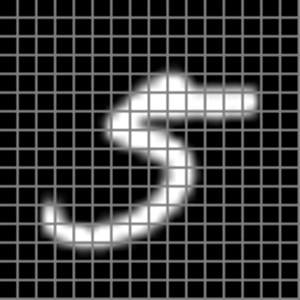
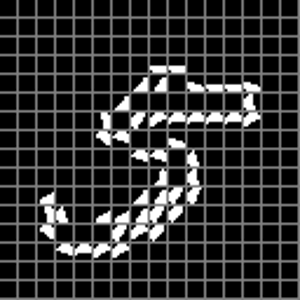
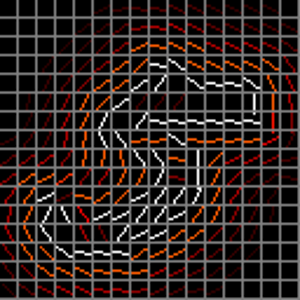

In [36]:
images = []
captions = []

image_index = RNG.choice(len(x_train))
image_index = 11198 # 5
# image_index = 3 # 1
random_img_data = x_train[image_index]
random_img = Image.frombytes('L', size=(28, 28), data=random_img_data)
random_img = random_img.resize((config.sample_size, config.sample_size))
images.append(random_img)
captions.append(f'#{image_index}')

random_img_arr = xp.array([random_img])
random_img_arr = random_img_arr.reshape(1, -1)
random_img_encoding = xp_array_from_gpu(sense_images(random_img_arr))
random_img_encoding = random_img_encoding.reshape(SENSOR_GROUPS_COUNT, -1)
assert (random_img_encoding == 1).sum() > 0

sz = config.sample_size
layers = []

for sensor_group_index, sensor_group in enumerate(random_img_encoding):
    assert sensor_group.shape == (SENSOR_GROUP_SQUARE, )
    
    if np.all(sensor_group == 0):
        continue
        
    # Find most similar reaction among specific samples of reactions for given sensor group by hamming dist
    speficic_samples_encodings_for_sensor_group = SPECIFIC_SAMPLES_ENCODINGS[sensor_group_index]
    a = sensor_group
    b = speficic_samples_encodings_for_sensor_group[:,sensor_group_index * SENSOR_GROUP_SQUARE:sensor_group_index * SENSOR_GROUP_SQUARE + SENSOR_GROUP_SQUARE]
    hamming_dist = np.count_nonzero(a != b, axis=1)
    best_i = np.argmin(hamming_dist)
    most_similar_specific_sample = np.array(SPECIFIC_SAMPLES_IMG[sensor_group_index][best_i])
    assert most_similar_specific_sample.shape == (sz, sz)
    layers.append(most_similar_specific_sample)

normal_map = encoding_to_normal_map(random_img_encoding.ravel())
# normal_map[np.absolute(normal_map) > 0.49] = 0 # DROP high frequency normals
normal_color_map = mpl.colormaps['hot']
normal_map_image = Image.new('RGBA', (sz, sz), color='black')
normal_map_image_draw = ImageDraw.Draw(normal_map_image)
k = sz / normal_map.shape[0]
k_half = k / 2

for i in range(normal_map.shape[0]):
    for j in range(normal_map.shape[1]):
        normal = normal_map[i, j]

        if normal == 0:
            continue
        
        tangent = normal.imag, normal.real # manual transpose (rotate 90)
        tangent /= np.linalg.norm(tangent)
        center_x = (j + 0.5) * k
        center_y = (i + 0.5) * k
        line_start = center_x + tangent[0] * k_half, center_y + tangent[1] * k_half
        line_end = center_x - tangent[0] * k_half, center_y - tangent[1] * k_half
        normal_color = normal_color_map(np.absolute(normal), bytes=True)
        # normal_color = normal_color_map(1.0, bytes=True)
        normal_map_image_draw.line([line_start, line_end], fill=normal_color)

sensor_map_image = np.zeros((sz, sz))

for layer in layers:
    sensor_map_image += layer
    
sensor_map_image[sensor_map_image != 0] = 255
images.append(matrix_to_image(sensor_map_image))
images.append(normal_map_image)
captions.extend([''] * 2)

lay_grid_local = lambda i: lay_grid(i, 8)
display_images(list(map(lambda i: lay_grid_local(i).resize((300, 300)), images)), captions=captions)

In [37]:
xy_offsets = np.concat([[[0, 0]], get_clock_offsets([5, 3, 1])])
img_data = x_train[image_index]

with Image.frombytes('L', size=(28, 28), data=img_data) as img:
    img = img.resize((config.sample_size, config.sample_size))
    image_offsets = xp_array_to_gpu(generate_image_offsets(np.array(img).ravel(), xy_offsets))

image_offset_encodings = xp_array_from_gpu(sense_images(image_offsets))
assert image_offset_encodings.shape == (image_offsets.shape[0], SENSORS_COUNT)

In [38]:
hdvs_old = []

for image_offset_encoding in tqdm(image_offset_encodings):
    hdvs_old.append(encoding_to_hdv(image_offset_encoding))

hdvs_old = np.array(hdvs_old)
hdvs_old = hdc.normalize(hdvs_old)
cross_sim = hdvs_old @ hdvs_old.T
cross_sim = cross_sim[np.tril_indices(cross_sim.shape[0], -1)] # exclude dups and self cross sims
pd.Series(cross_sim).describe()

  0%|          | 0/29 [00:00<?, ?it/s]

count    406.000000
mean       0.370982
std        0.142148
min        0.054230
25%        0.265944
50%        0.365359
75%        0.478604
max        0.747468
dtype: float64

In [39]:
%%time
hdvs_new = []

for image_offset_encoding in tqdm(image_offset_encodings):
    normal_map = encoding_to_normal_map(image_offset_encoding)
    image_offset_encoding = normal_map_to_encoding(normal_map)
    hdvs_new.append(encoding_to_hdv(image_offset_encoding))

hdvs_new = np.array(hdvs_new)
hdvs_new = hdc.normalize(hdvs_new)
cross_sim = hdvs_new @ hdvs_new.T
cross_sim = cross_sim[np.tril_indices(cross_sim.shape[0], -1)] # exclude dups and self cross sims
pd.Series(cross_sim).describe()

  0%|          | 0/29 [00:00<?, ?it/s]

CPU times: user 815 ms, sys: 8 ms, total: 823 ms
Wall time: 816 ms


count    406.000000
mean       0.580105
std        0.055385
min        0.451457
25%        0.543131
50%        0.574926
75%        0.612357
max        0.782542
dtype: float64

In [40]:
pd.Series(np.absolute(normal_map.ravel())).describe()

count    256.000000
mean       0.368961
std        0.351112
min        0.000000
25%        0.090784
50%        0.250000
75%        0.500000
max        1.000000
dtype: float64


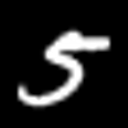
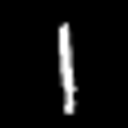

In [41]:
img_data2 = x_train[8]

with Image.frombytes('L', size=(28, 28), data=img_data2) as img2:
    img2 = img2.resize((config.sample_size, config.sample_size))
    image_offsets2 = xp_array_to_gpu(generate_image_offsets(np.array(img2).ravel(), xy_offsets))

image_offset_encodings2 = xp_array_from_gpu(sense_images(image_offsets2))
assert image_offset_encodings2.shape == (image_offsets2.shape[0], SENSORS_COUNT)
display_images([img, img2])

In [42]:
hdvs_other_old = []

for image_offset_encoding in tqdm(image_offset_encodings2):
    hdvs_other_old.append(encoding_to_hdv(image_offset_encoding))

hdvs_other_old = np.array(hdvs_other_old)
hdvs_other_old = hdc.normalize(hdvs_other_old)
cross_sim = hdvs_old @ hdvs_other_old.T
cross_sim = cross_sim[np.tril_indices(cross_sim.shape[0], -1)] # exclude dups and self cross sims
pd.Series(cross_sim).describe()

  0%|          | 0/29 [00:00<?, ?it/s]

count    406.000000
mean       0.085390
std        0.017178
min        0.040363
25%        0.073196
50%        0.085082
75%        0.096231
max        0.132567
dtype: float64

In [43]:
%%time
hdvs_other_new = []

for image_offset_encoding in tqdm(image_offset_encodings2):
    normal_map = encoding_to_normal_map(image_offset_encoding)
    image_offset_encoding = normal_map_to_encoding(normal_map)
    hdvs_other_new.append(encoding_to_hdv(image_offset_encoding))

hdvs_other_new = np.array(hdvs_other_new)
hdvs_other_new = hdc.normalize(hdvs_other_new)
cross_sim = hdvs_new @ hdvs_other_new.T
cross_sim = cross_sim[np.tril_indices(cross_sim.shape[0], -1)] # exclude dups and self cross sims
pd.Series(cross_sim).describe()

  0%|          | 0/29 [00:00<?, ?it/s]

CPU times: user 899 ms, sys: 7.16 ms, total: 906 ms
Wall time: 564 ms


count    406.000000
mean       0.283100
std        0.018022
min        0.229569
25%        0.271144
50%        0.282990
75%        0.296858
max        0.334949
dtype: float64

# Tables 'images', 'image_encodings', 'image_encoding_hdv_bundles'

In [44]:
def create_datasets(x_dataset, y_dataset, samples_count, id_offset):
    image_indices = RNG.choice(len(x_dataset), samples_count, replace=False)
    image_dataset = defaultdict(list)
    image_encoding_dataset = defaultdict(list)

    if config.encoding_type == 'exnormal':
        xy_offsets = [[0, 0]]
    else:
        xy_offsets_grid = get_grid_offsets(-2, 2)
        xy_offsets_clock = get_clock_offsets([5, 3])
        xy_offsets = np.array(list(set(map(lambda x: (int(x[0]), int(x[1])), chain(xy_offsets_grid, xy_offsets_clock)))))
        xy_offsets = np.concat([[[0, 0]], xy_offsets])
    
    for i in tqdm(image_indices):
        img_data = x_dataset[i]
        img_label = y_dataset[i]
    
        with Image.frombytes('L', size=(28, 28), data=img_data) as img:
            b = io.BytesIO()
            img = img.resize((config.sample_size, config.sample_size))
            img.save(b, format='PNG')
            png = b.getvalue()
    
            image_id = i + id_offset
            image_dataset['image_id'].append(image_id)
            image_dataset['value'].append(str(img_label))
            image_dataset['png'].append(png)
    
            image_offsets = generate_image_offsets(np.array(img).ravel(), xy_offsets)
            image_offset_encodings = sense_images(xp.array(image_offsets)) # 98% of time consumes this call! mp.Pool can't speed up create_dataset =(
            
            for ioe, (x, y) in zip(image_offset_encodings, xy_offsets):
                if config.encoding_type == 'exnormal':
                    normal_map = encoding_to_normal_map(xp_array_from_gpu(ioe))
                    ioe = normal_map_to_encoding(normal_map).astype('b')
                else:
                    ioe = xp_array_from_gpu(ioe).astype('b')

                for column_id in range(-1, config.cortical_columns_count): # -1 is used to store original encoding
                    image_encoding_dataset['image_id'].append(image_id)
                    image_encoding_dataset['column_id'].append(column_id)
                    image_encoding_dataset['offset_x'].append(x)
                    image_encoding_dataset['offset_y'].append(y)

                    if column_id == -1:
                        image_encoding_dataset['encoding'].append(ioe)
                    else:
                        column_rec_field = CORTICAL_COLUMN_RECEPTIVE_FIELDS[column_id]
                        assert column_rec_field.shape == ioe.shape
                        column_ioe = ioe * column_rec_field # masking
                        image_encoding_dataset['encoding'].append(column_ioe)
    
    image_dataset = pd.DataFrame(image_dataset)
    image_encoding_dataset = pd.DataFrame(image_encoding_dataset)
    return image_dataset, image_encoding_dataset

def save_datasets(image_dataset, image_encoding_dataset, db_con):
    image_dataset.to_sql(name='images', con=db_con)
    image_encoding_dataset.to_sql(name='image_encodings', con=db_con)

    cur = db_con.cursor()
    cur.execute('CREATE INDEX ix_images_image_id ON images(image_id)')
    cur.execute('CREATE INDEX ix_image_encodings_image_id ON image_encodings(image_id)')
    cur.execute('CREATE INDEX ix_image_encodings_column_id ON image_encodings(column_id)')
    cur.execute('CREATE INDEX ix_image_encodings_image_id_column_id ON image_encodings(image_id, column_id)')
    cur.execute('ALTER TABLE image_encodings ADD COLUMN hdv BLOB')
    db_con.commit()

In [45]:
%%time
train_tuple = (train_db_con, x_train, y_train, config.dataset_train_samples_count, 0)
test_tuple = (test_db_con, x_test, y_test, config.dataset_test_samples_count, 100_000_000)

for db_con, x, y, samples_count, id_offset in [train_tuple, test_tuple]:
    if not is_table_exists(db_con, 'images'):
        image_dataset, image_encoding_dataset = create_datasets(x, y, samples_count, id_offset)
        save_datasets(image_dataset, image_encoding_dataset, db_con)

CPU times: user 7.55 ms, sys: 985 μs, total: 8.54 ms
Wall time: 1.69 ms


In [46]:
# %%time
# train_tuple = (train_db_con, x_train, y_train, config.dataset_train_samples_count, 0)
# test_tuple = (test_db_con, x_test, y_test, config.dataset_test_samples_count, 100_000_000)

# for db_con, x, y, samples_count, id_offset in [train_tuple, test_tuple]:
#     drop_table_safe(db_con, 'image_encodings')
#     drop_table_safe(db_con, 'image_encoding_hdv_bundles')
#     drop_table_safe(db_con, 'images')
#     db_con.commit()

In [48]:
%%time

def is_any_hdv_missing(db_con):
    cur = db_con.cursor() 
    rows = cur.execute('SELECT 1 FROM image_encodings WHERE (hdv IS NULL OR LENGTH(hdv)<>:hdv_N) LIMIT 1', {'hdv_N': config.hdc_n}).fetchall()
    return len(rows) > 0

def mp_encoding_to_hdv(task):
    enc_index, encoding = task
    encoding_hdv = encoding_to_hdv(encoding)
    return (enc_index, encoding_hdv)

def make_image_encoding_hdvs(db_con):
    df_image_encodings = pd.read_sql('SELECT "index", encoding FROM image_encodings WHERE (hdv IS NULL OR LENGTH(hdv)<>:hdv_N)', params={'hdv_N': config.hdc_n}, con=db_con)
    batch_size = max(4, mp.cpu_count() - 1)

    def run_pending_tasks(async_task_results, new_tasks, is_drain=False):
        cycles = 2 if is_drain else 1

        for _ in range(cycles):
            task_results = async_task_results.get() if async_task_results else None
            async_task_results = pool.map_async(mp_encoding_to_hdv, new_tasks) if new_tasks else None
            new_tasks = None
    
            if task_results:
                # While new tasks are being executed we persist data from previous run (interleaved CPU and IO tasks)
                executemany_params = list(map(lambda tr: {'index': tr[0], 'hdv': tr[1].tobytes()}, task_results))
                cur.executemany('UPDATE image_encodings SET hdv=:hdv WHERE "index"=:index', executemany_params)
                db_con.commit()
    
        return async_task_results
    
    with mp.Pool(processes=batch_size) as pool:
        cur = db_con.cursor()
        async_task_result = None
        tasks = []

        for _, enc_row in tqdm(df_image_encodings.iterrows(), total=len(df_image_encodings)):
            enc_index = int(enc_row['index'])
            encoding = np.frombuffer(enc_row['encoding'], dtype='b')
            tasks.append((enc_index, encoding))

            if len(tasks) >= batch_size:
                async_task_result = run_pending_tasks(async_task_result, tasks)
                tasks = []

        # Complete pending tasks and drain remaining
        run_pending_tasks(async_task_result, tasks, is_drain=True)
                

for db_con in [train_db_con, test_db_con]:
    if is_any_hdv_missing(db_con):
        make_image_encoding_hdvs(db_con)

CPU times: user 85.8 ms, sys: 128 ms, total: 214 ms
Wall time: 212 ms


In [48]:
%%time

for db_con in [train_db_con, test_db_con]:
    if not is_table_exists(db_con, 'image_encoding_hdv_bundles'):
        cur = db_con.cursor()
        cur.execute('CREATE TABLE image_encoding_hdv_bundles(image_id INTEGER, column_id INTEGER, hdv_bundle TEXT)')
        cur.execute('CREATE INDEX ix_image_encoding_hdv_bundles_image_id ON image_encoding_hdv_bundles(image_id)')
        cur.execute('CREATE INDEX ix_image_encoding_hdv_bundles_column_id ON image_encoding_hdv_bundles(column_id)')
        cur.execute('CREATE UNIQUE INDEX ix_image_encoding_hdv_bundles_image_id_column_id ON image_encoding_hdv_bundles(image_id, column_id)')
        db_con.commit()

    df_image_wo_bundles = pd.read_sql('SELECT i.image_id FROM images i LEFT JOIN image_encoding_hdv_bundles b ON i.image_id=b.image_id WHERE b.image_id IS NULL', con=db_con)

    if len(df_image_wo_bundles) == 0:
        continue
    
    executemany_params = []

    for image_id in tqdm(df_image_wo_bundles['image_id']):
        df_hdvs = pd.read_sql('SELECT column_id, hdv FROM image_encodings WHERE image_id=:image_id', params={'image_id': image_id}, con=db_con)
        
        for column_id in df_hdvs['column_id'].unique():
            column_id = int(column_id)
            hdvs = df_hdvs.loc[df_hdvs['column_id'] == column_id]['hdv']
            hdvs = list(map(lambda hdv: np.frombuffer(hdv, dtype='b'), hdvs))
            hdv_bundle = hdc.bundle(hdvs)
            executemany_params.append({'image_id': image_id, 'column_id': column_id, 'hdv_bundle': hdv_bundle.tobytes()})
        
    cur = db_con.cursor()
    cur.executemany('INSERT INTO image_encoding_hdv_bundles (image_id, column_id, hdv_bundle) VALUES (:image_id, :column_id, :hdv_bundle)', executemany_params)
    db_con.commit()

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 58.3 s, sys: 2.5 s, total: 1min
Wall time: 1min


In [53]:
df_image_encodings = pd.read_sql('SELECT "index", hdv FROM image_encodings WHERE "index"=0 LIMIT 1', con=train_db_con)

for enc_index, enc_row in df_image_encodings.iterrows():
    hdv = np.frombuffer(enc_row['hdv'], dtype='b')
    assert hdv.shape[0] == hdc.N
    print(len(enc_row['hdv']), hdv.shape, np.unique_counts(hdv))    

10000 (10000,) UniqueCountsResult(values=array([-1,  0,  1], dtype=int8), counts=array([5113,  281, 4606]))


CPU times: user 348 ms, sys: 31 ms, total: 379 ms
Wall time: 377 ms



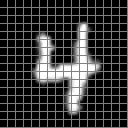
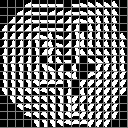
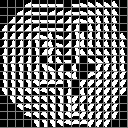

In [56]:
%%time
empty_image = Image.new('L', size=(1,1), color=255)
images = []
captions = []
col_count = 8

df_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
image_id = RNG.choice(df_images.index.unique())
image_id = 11670
image_data = df_images.loc[image_id]['png']
image = Image.open(io.BytesIO(image_data))
images.append(image)
captions.append(f'{image_id}, val={df_images.loc[image_id]['value']}')
images.extend([empty_image] * (col_count - 1))
captions.extend([''] * (col_count - 1))

column_id = -1
df_encodings = pd.read_sql_query('SELECT encoding, offset_x, offset_y, hdv FROM image_encodings WHERE image_id=:image_id AND column_id=:column_id', 
                                 params={'image_id': int(image_id), 'column_id': column_id}, 
                                 con=train_db_con)
sz = config.sample_size
encodings = []
bundle_layers = []

for _, enc_row in df_encodings.iterrows():
    encoding = np.frombuffer(enc_row['encoding'], dtype='b')
    encodings.append(encoding)
    encoding_dims = encoding.shape[0]
    encoding = encoding.reshape(SENSOR_GROUPS_COUNT, -1)
    layers = []

    for sensor_group_index, sensor_group in enumerate(encoding):
        assert sensor_group.shape == (SENSOR_GROUP_SQUARE, )
        speficic_samples_reactions_for_sensor_group = SPECIFIC_SAMPLES_ENCODINGS[sensor_group_index]
        
        if np.any(sensor_group > 0):
            # Find most similar reaction among specific samples of reactions for given sensor group
            a = np.zeros(encoding_dims)
            assert a.shape[0] == speficic_samples_reactions_for_sensor_group.shape[1]
            a[sensor_group_index * SENSOR_GROUP_SQUARE:sensor_group_index * SENSOR_GROUP_SQUARE + SENSOR_GROUP_SQUARE] = sensor_group
            a = a / np.linalg.norm(a)
            b = speficic_samples_reactions_for_sensor_group
            b = (b.T / np.linalg.norm(b, axis=1)).T
            cos_sim = (a @ b.T)
            best_i = np.argmax(cos_sim)
            most_similar_specific_sample = np.array(SPECIFIC_SAMPLES_IMG[sensor_group_index][best_i])
            assert most_similar_specific_sample.shape == (sz, sz)
            layers.append(most_similar_specific_sample)
            bundle_layers.append(most_similar_specific_sample)

    sensor_map_image = np.zeros((sz, sz))
    
    for layer in layers:
        sensor_map_image += layer

    sensor_map_image[sensor_map_image != 0] = 255
    images.append(Image.frombytes('L', (sz, sz), data=sensor_map_image.ravel().astype('b')))
    captions.append(f'offset={enc_row['offset_x']}, {enc_row['offset_y']}')

bundle_sensor_map_image = np.zeros((sz, sz))
    
for layer in bundle_layers:
    bundle_sensor_map_image += layer

bundle_sensor_map_image[bundle_sensor_map_image != 0] = 255
images[1] = matrix_to_image(bundle_sensor_map_image)
captions[1] = 'bundle'

lay_grid_local = lambda i: lay_grid(i, 8)
display_images_grid(list(map(lay_grid_local, images)), captions=captions, col_count=col_count)

In [51]:
encodings = []
encoding_dims = 0
hdvs = []

for _, enc_row in df_encodings.iterrows():
    encoding = np.frombuffer(enc_row['encoding'], dtype='b')
    encodings.append(encoding)

    if encoding_dims:
        assert encoding_dims == encoding.shape[0]
    else:
        encoding_dims = encoding.shape[0]
        
    hdv = np.frombuffer(enc_row['hdv'], dtype='b')
    hdvs.append(hdv)

hdvs_bundle1 = hdc.bundle(hdvs) # 1) bundle horizontally (all strides within each encoding) 2) bundle vertically (all enconding bundles)

assert encoding_dims > 0
stride_encoding_hdvs_bundles = []

for stride_index in range(0, encoding_dims, SENSOR_GROUP_SQUARE):
    stride_encoding_hdvs = []
    
    for encoding in encodings:
        stride = encoding[stride_index:stride_index + SENSOR_GROUP_SQUARE]
        stride_code = ''.join(map(str, stride.tolist()))

        if not stride_code.replace('0', ''): # for relatively short strides this is ~x2 faster than np.all(stride == 0) or np.max(stride) == 0
            continue

        assert stride_code in STRIDE_HDVS
        stride_hdv = STRIDE_HDVS[stride_code]
        stride_hdv = hdc.shift(stride_hdv, stride_index)
        stride_encoding_hdvs.append(stride_hdv)

    if stride_encoding_hdvs:
        stride_encoding_hdvs_bundle = hdc.bundle(stride_encoding_hdvs)
        stride_encoding_hdvs_bundles.append(stride_encoding_hdvs_bundle)

hdvs_bundle2 = hdc.bundle(stride_encoding_hdvs_bundles) # 1) bundle vertically (all strides with the same indices) 2) bundle horizontally (all stride bundles)
hdc.sim(hdvs_bundle1, hdvs_bundle2)

np.float64(1.0)